In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
import bq
import time

In [128]:
cellsize = .1
one_over_cellsize = 10
if cellsize < 1:
    num_lons = 360*one_over_cellsize
    num_lats = 180 *one_over_cellsize
else:
    num_lons = 360/cellsize
    num_lats = 180/cellsize

In [118]:
def get_area(lat):
    lat_degree = 69 # miles
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0        
    # phi = 90 - latitude
    phi = (lat+cellsize/2.)*degrees_to_radians #plus half a cell size to get the middle
    lon_degree = math.cos(phi)*lat_degree 
    # return 69*69*2.6
    return  lat_degree*lon_degree* 2.58999 # miles to square km

In [112]:
client = bq.Client.Get()
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [115]:
# query to get the density of vessels
vessel_query = []

for i in range(4):
    q = '''
    SELECT 
    integer(lat*'''+str(one_over_cellsize)+''') lat_bin,
    integer(lon*'''+str(one_over_cellsize)+''') lon_bin,
    sum(1/positions) vessels
    FROM [scratch_david_gapanalysis.orbcomm_2015_noduplicates_st_stats]
    where  
      max_lat - min_lat <5
      AND (max_lon - min_lon < 10 // This lon filter cuts out 2.7 percent of the data 
        OR first_lon > 170
        OR first_lon < -170)
      and lat > -90 and lat < 90 and lat != 0 
      //divide into 4 parts because a single query is too big for this api
      and lon > '''+ str(i*90-180) + ''' and lon < '''+ str(i*90-90)+'''
      AND mmsi IN (select mmsi from
    [scratch_david_gapanalysis.good_mmsi_2015])
    //and tagblock_type = 'terrestrial'
    group by lat_bin, lon_bin
    '''
    vessel_query += Query(q)

Waiting on bqjob_r405fa20441fbb523_0000015314aab430_12 ... (34s) Current status: DONE   
Query time: 100.596560955 seconds.
Waiting on bqjob_r6a4bd9e467babf4d_0000015314ac3d36_13 ... (34s) Current status: DONE   
Query time: 101.024713993 seconds.
Waiting on bqjob_r5117ad6fd0bf7bb7_0000015314adc7e8_14 ... (48s) Current status: DONE   
Query time: 108.035313845 seconds.
Waiting on bqjob_r542b6a0e82a712b1_0000015314af6dff_15 ... (34s) Current status: DONE   
Query time: 98.5088191032 seconds.


In [175]:
vessel_days = np.zeros(shape=(num_lats,num_lons))

for row in vessel_query:
    lat = int(row[0])
    lon = int(row[1])
    if lat<90*one_over_cellsize and lat>-90*one_over_cellsize and lon>-180*one_over_cellsize and lon<180*one_over_cellsize:
        lat_index = lat+90*one_over_cellsize
        lon_index = lon+180*one_over_cellsize
        days = float(row[2])
        area = get_area(lat*float(cellsize)) # approximate area of 1 by 1 degree at a given lat
        vessel_days[lat_index][lon_index] = days / (365.* area*cellsize*cellsize)*1000 #vessels per day per square km

        
        

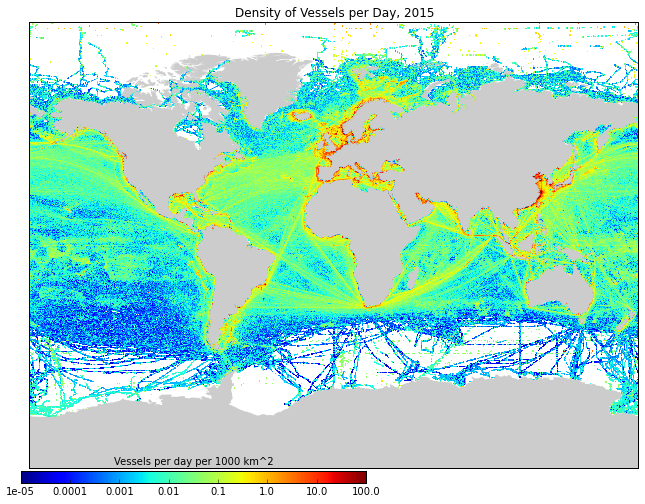

In [176]:
firstlat = 90
lastlat = -90
firstlon = -180
lastlon = 180
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=firstlon, urcrnrlon=lastlon, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary()
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar


m3 = 100**.33333+.01
maximum = 100
minimum = .00001

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, vessel_days, norm=norm, vmin=.00001, vmax=m3**3)

t = "Density of Vessels per Day, 2015"
plt.title(t)

ax = fig.add_axes([0.15, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels([i for i in lvls], fontsize=10)
cb.set_label('Vessels per day per 1000 km^2',labelpad=-40, y=0.45)
plt.savefig("vessel_density_2015.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=0)
plt.rcParams["figure.figsize"] = [12,8]
plt.show()


In [108]:
vessel_days.dump((open('../../data/density/density2015.npy', 'wb')))

In [143]:
norm


In [168]:
lvls

array([  1.00000000e-05,   1.46779927e-04,   2.15443469e-03,
         3.16227766e-02,   4.64158883e-01,   6.81292069e+00,
         1.00000000e+02])

In [149]:
np.log(100)

4.6051701859880918

In [173]:
np.logspace(np.log10(minimum),np.log10(maximum), num = 8)


array([  1.00000000e-05,   1.00000000e-04,   1.00000000e-03,
         1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
         1.00000000e+01,   1.00000000e+02])

In [163]:
np.log10(maximum)

4.6051701859880918

In [154]:
minimum


1e-05

In [155]:
np.log(minimum)

-11.512925464970229

In [156]:
np.logspace(0,3,7)

array([    1.        ,     3.16227766,    10.        ,    31.6227766 ,
         100.        ,   316.22776602,  1000.        ])

In [160]:
3.06954875e-12

3.06954875e-12

In [170]:
vessel_days[vessel_days==0] = 1
vessel_days.min()

1.1722694055578091e-05